<a href="https://colab.research.google.com/github/hane94/Machine-Learning-Practice/blob/master/lesson4_collab(hyeseon)_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from fastai.collab import *
from fastai.tabular import *

## Collaborative filtering example

협업 필터링 : 사용자들로부터 얻은 기호정보(taste information)에 따라 사용자들의 관심사들을 자동적으로 예측하게 해주는 방법

`collab` models use data in a `DataFrame` of user, items, and ratings.

In [0]:
user,item,title = 'userId','movieId','title'

In [0]:
path = untar_data(URLs.ML_SAMPLE)
path

PosixPath('/root/.fastai/data/movie_lens_sample')

In [0]:
ratings = pd.read_csv(path/'ratings.csv') #사용자의 평가 데이터
ratings.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


That's all we need to create and train a model:

In [0]:
data = CollabDataBunch.from_df(ratings, seed=42)

In [0]:
y_range = [0,5.5]

In [0]:
learn = collab_learner(data, n_factors=50, y_range=y_range) #러너 생성

In [0]:
learn.fit_one_cycle(3, 5e-3) #3번 학습시키기

epoch,train_loss,valid_loss,time
0,1.623438,0.942436,00:01
1,0.846226,0.681955,00:00
2,0.665326,0.683445,00:00


## Movielens 100k

Let's try with the full Movielens 100k data dataset, available from http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [0]:
path=Path('/content/drive/My Drive/Colab Notebooks/lesson4/ml-100k')

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None, #Don't add header row
                      names=[user,item,'rating','timestamp']) #header row를 넣지 않기때문에 넣어줘야하는 이름들
ratings.head() #user movie ratings

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [0]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1', header=None, #유니코드 파일이 아닌 것을 읽어오기 위해 필요한 코드 encoding
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]]) #영화에 대한 유저의 평점
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [0]:
len(ratings)

100000

In [0]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [0]:
data = CollabDataBunch.from_df(rating_movie, seed=42, valid_pct=0.1, item_name=title) #title열을 사용하겠다

In [0]:
data.show_batch()

userId,title,target
654,Playing God (1997),3.0
354,"Seventh Seal, The (Sjunde inseglet, Det) (1957)",3.0
835,Jerry Maguire (1996),4.0
892,"Philadelphia Story, The (1940)",5.0
699,Eraser (1996),3.0


In [0]:
y_range = [0,5.5] #final activationi function //sigmode

In [0]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


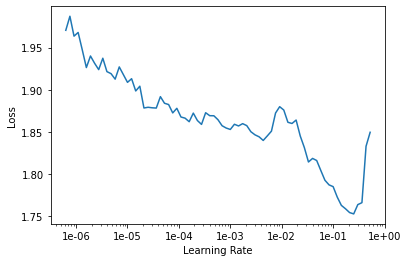

In [0]:
learn.lr_find()
learn.recorder.plot(skip_end=15) 

In [0]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.953107,0.948426,00:09
1,0.875113,0.878407,00:09
2,0.760783,0.837905,00:09
3,0.656841,0.810754,00:09
4,0.545420,0.809093,00:09


In [0]:
learn.save('dotprod')

Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91, which corresponds to an MSE of `0.91**2 = 0.83`.

## Interpretation

### Setup

In [0]:
learn.load('dotprod');

In [0]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

In [0]:
g = rating_movie.groupby(title)['rating'].count() #무비 테이블을 읽어오기 위해 판다스 사용 #레이팅 개수 세는 것count
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10] #가장 높은 레이팅의 무비

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

### Movie bias

In [0]:
movie_bias = learn.bias(top_movies, is_item=True) #1000movie
movie_bias.shape

torch.Size([1000])

In [0]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)] #b,i bias

In [0]:
item0 = lambda o:o[0]

In [0]:
sorted(movie_ratings, key=item0)[:15] #lowest number

[(tensor(-0.3556),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.3140),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2987), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2824), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2586), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2564), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2473), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2385), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2210), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2206), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.2119), 'Tales from the Hood (1995)', 2.037037037037037),
 (tensor(-0.2047), "Joe's Apartment (1996)", 2.2444444444444445),
 (tensor(-0.2040), 'Home Alone 3 (1997)', 1.894736842105263),
 (tensor(-0.2021), 'Grease 2 (1982)', 2.0),
 (tensor(-0.2008), 'Beautician a

In [0]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.6088), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5774), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5636), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5574), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5487), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.5317), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5314), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.4890), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.4817), 'Godfather, The (1972)', 4.283292978208232),
 (tensor(0.4778), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4726), 'Apt Pupil (1998)', 4.1),
 (tensor(0.4715), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.4658), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.4611), 'Boot, Das (1981)', 4.203980099502488),
 (tensor(0.4608), 'Vertigo (1958)', 4.251396648044692)]

### Movie weights

In [0]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

In [0]:
movie_pca = movie_w.pca(3) #PCA 메서드 / simple linear trasformation that takes an input matrix and tries to find a smaller number of columns
movie_pca.shape

torch.Size([1000, 3])

In [0]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [0]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1452), 'Wrong Trousers, The (1993)'),
 (tensor(1.0705), 'Casablanca (1942)'),
 (tensor(1.0226), 'Chinatown (1974)'),
 (tensor(1.0181), 'Close Shave, A (1995)'),
 (tensor(1.0001), 'When We Were Kings (1996)'),
 (tensor(0.9945), 'Secrets & Lies (1996)'),
 (tensor(0.9817), 'Lawrence of Arabia (1962)'),
 (tensor(0.9685), '12 Angry Men (1957)'),
 (tensor(0.9419), 'Third Man, The (1949)'),
 (tensor(0.9387), 'Persuasion (1995)')]

In [0]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.3415), "McHale's Navy (1997)"),
 (tensor(-1.2450), 'Jungle2Jungle (1997)'),
 (tensor(-1.1801), 'Leave It to Beaver (1997)'),
 (tensor(-1.1344), 'Bio-Dome (1996)'),
 (tensor(-1.1134), 'Home Alone 3 (1997)'),
 (tensor(-1.1115), 'Children of the Corn: The Gathering (1996)'),
 (tensor(-1.0892), 'Free Willy 3: The Rescue (1997)'),
 (tensor(-1.0812), 'D3: The Mighty Ducks (1996)'),
 (tensor(-1.0439), 'Mortal Kombat: Annihilation (1997)'),
 (tensor(-1.0352), 'Grease 2 (1982)')]

In [0]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [0]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.8423), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(0.8039), 'Crumb (1994)'),
 (tensor(0.8019), 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)'),
 (tensor(0.7890), 'Clockwork Orange, A (1971)'),
 (tensor(0.7836), 'Stupids, The (1996)'),
 (tensor(0.7462), 'Beavis and Butt-head Do America (1996)'),
 (tensor(0.7425), 'Brazil (1985)'),
 (tensor(0.7319), 'Heavenly Creatures (1994)'),
 (tensor(0.7280), 'Trainspotting (1996)'),
 (tensor(0.7273), 'Keys to Tulsa (1997)')]

In [0]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.2495), 'Braveheart (1995)'),
 (tensor(-1.0479), 'Raiders of the Lost Ark (1981)'),
 (tensor(-1.0391), 'Titanic (1997)'),
 (tensor(-0.8940), 'American President, The (1995)'),
 (tensor(-0.8501), 'Independence Day (ID4) (1996)'),
 (tensor(-0.8413), 'Forrest Gump (1994)'),
 (tensor(-0.8329), 'Sleepless in Seattle (1993)'),
 (tensor(-0.8298), 'Shawshank Redemption, The (1994)'),
 (tensor(-0.8216), 'Pretty Woman (1990)'),
 (tensor(-0.8186), 'Air Force One (1997)')]

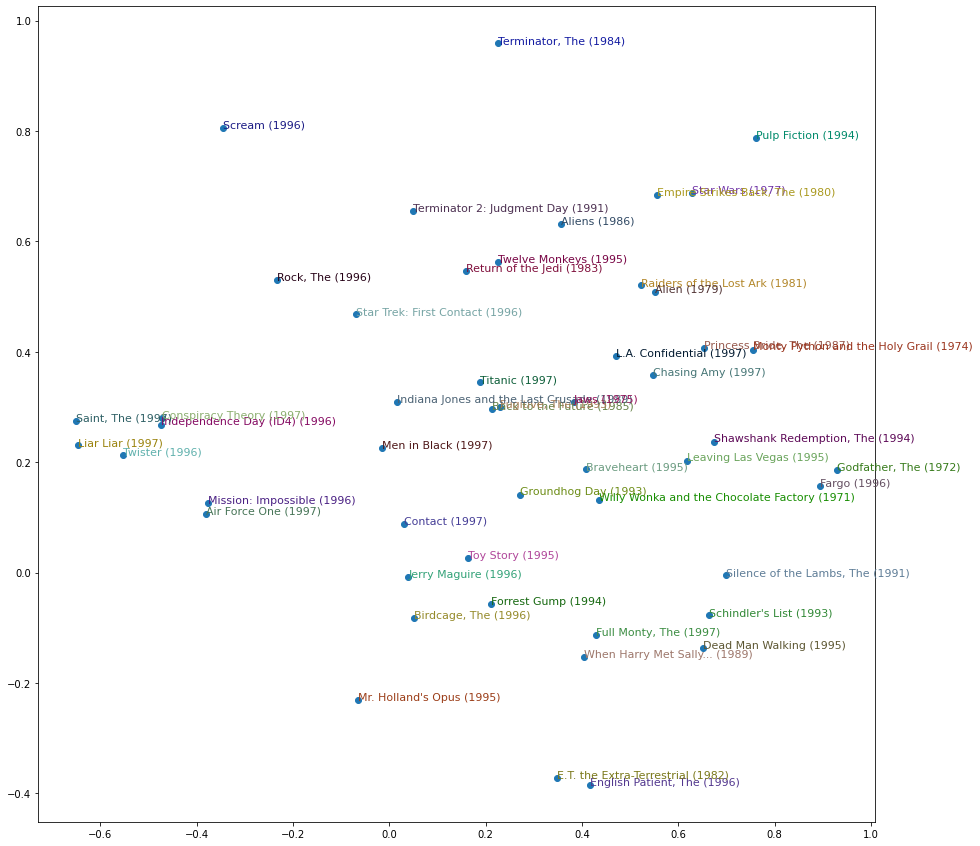

In [0]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show() #graph , top 50 most popular movie